In [ ]:
import sys
print(sys.executable)

c:\Users\benjb\OneDrive\Documents\GitHub\Eden-finance\.venv\Scripts\python.exe


In [1]:
import yfinance as yf

In [1]:
import yfinance as yf
import IPython
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def value_change(row, start_val, initial_price):
    value = float((row/initial_price)*start_val)
    return value

In [3]:
def inv_calc(start_date, end_date, stocks):
    if not all(isinstance(item, tuple) and len(item) == 2 for item in stocks):
        return "Input a Ticker and a Value"
    else:
        tickers = [ticker for ticker, _ in stocks]
        investments = dict(stocks)
        starting_val = sum(investments.values())
        prices  = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, progress=False).Close
        latest_prices = prices.iloc[-1]
        initial_prices = prices.iloc[0]
        for item in investments:
            start_val = float(investments[item])
            initial_price = float(prices[f"{item}"].iloc[0])
            prices[f"{item}_value"] = ((pd.to_numeric(prices[item], errors="coerce")/initial_price)*start_val)
        
        prices.plot(
            x="Date",
            y=[f"{item}_value" for item in investments],
            figsize=(10, 5),
            title = "Value of Investments",
            grid=True
        )
        plt.show()

In [4]:
def inv_calc(start_date: str, end_date: str, stocks):
    """
    Parameters
    ----------
    start_date, end_date : str (yyyy-mm-dd)
    stocks               : iterable of (ticker, amount_in_£) tuples
    """
    # 1) Guard-rail checks -----------------------------------------------------
    if not stocks or not all(isinstance(t, tuple) and len(t) == 2 for t in stocks):
        raise ValueError("Stocks must be an iterable of (ticker, amount) tuples")

    tickers, amounts = zip(*stocks)
    amounts = pd.Series(amounts, index=tickers, dtype=float)  # £ invested

    # 2) Pull prices -----------------------------------------------------------
    raw = yf.download(list(tickers),
                      start=start_date,
                      end=end_date,
                      auto_adjust=True,
                      progress=False)

    # raw columns are         Open  High  Low  Close  Adj Close  Volume
    # keep *only* the Close rows and flatten any MultiIndex:
    close = raw["Close"]
    if isinstance(close, pd.Series):        # happens when just one ticker asked
        close = close.to_frame()

    close = close.loc[:, tickers]           # ensure column order matches 'amounts'
    close = close.sort_index()              # chronological order

    # 3) Vectorised value computation -----------------------------------------
    # multiplier = £invested / price_on_first_day
    initial_prices = close.iloc[0]
    multiplier = amounts / initial_prices    # Series indexed by ticker

    values = close.multiply(multiplier, axis=1)   # broadcast column-wise
    values.columns = [f"{c}_value" for c in values.columns]

    # 4) Plot ------------------------------------------------------------------
    ax = values.plot(figsize=(10, 5),
                     title="Value of Investments (£)",
                     grid=True)
    ax.set_xlabel("Date")
    ax.set_ylabel("£")
    plt.tight_layout()
    plt.show()

    return values

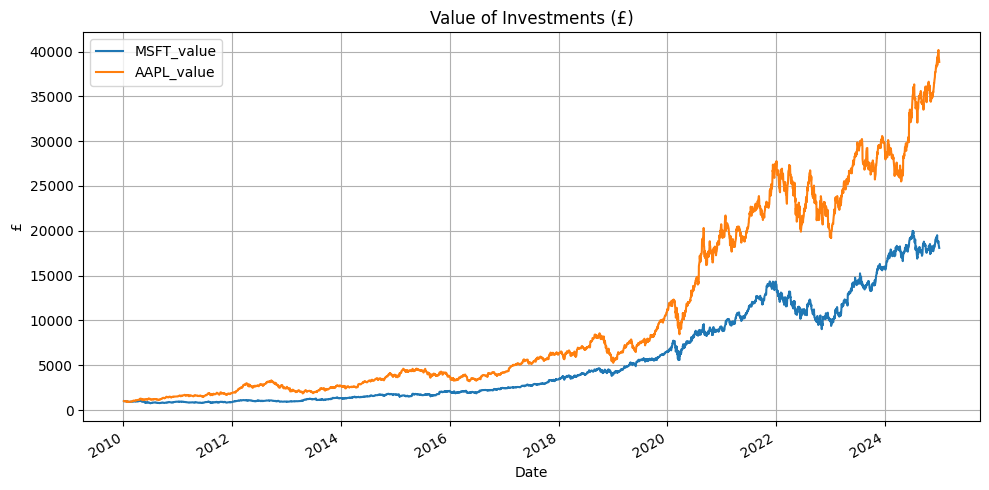

,MSFT_value,AAPL_value
Date,,
2010-01-04,1000.000000,1000.000000
2010-01-05,1000.322729,1001.729189
2010-01-06,994.183470,985.795241
2010-01-07,983.844453,983.972609
2010-01-08,990.629829,990.514698
...,...,...
2024-12-24,18854.807243,40047.085466
2024-12-26,18802.448922,40174.260163
2024-12-27,18477.136734,39642.264461


In [5]:
inv_calc("2010-01-01","2025-01-01",[("MSFT",1000),("AAPL",1000)])

In [34]:
companies = [('MSFT',1)]
output = inv_calc("2010-01-01","2025-01-01",companies)[0]
print(output)

18.089601370773554
